# Utils

In [66]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import LinearRegression

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import warnings
warnings.filterwarnings('ignore')

In [67]:
dataset_location = "C:/Users/thang/OneDrive/Desktop/school/DataChallenge/dataset_for_students/"

In [68]:
scene_df_1 = pd.read_hdf(dataset_location + 'scene.hdf5')
scene_df_2 = pd.read_hdf(dataset_location + 'scene2.hdf5')
scene_df_3 = pd.read_hdf(dataset_location + 'scene3.hdf5')


calibration_df_1 = pd.read_hdf(dataset_location +'calibration_set_1.hdf5')
calibration_df_2 = pd.read_hdf(dataset_location +'calibration_set_2.hdf5')

In [69]:
def display(scene_df, corrected_scene_images,index=15):
    plt.figure(figsize=(15, 5))

    # Original scene image
    plt.subplot(1, 2, 1)
    plt.title("Original Scene Image")
    plt.imshow(scene_df['image'][index], cmap='gray')

    # Denoised scene image
    plt.subplot(1, 2, 2)
    plt.title("Denoised Scene Image")
    plt.imshow(corrected_scene_images[index], cmap='gray')

    plt.show()

In [70]:
def process_data_np(df):
    df_image = df['image'].values
    return np.stack(df_image)

def process_data_tensor(df):
    df_images = df['image'].values
    df_images = np.array(df_images.tolist(), dtype=np.float32)
    df_images_tensor = torch.tensor(df_images, dtype=torch.float32).to(device)
    return df_images_tensor

# With calibration

In [71]:
def estimate_parameters(calibration_df):
    calibration_temperatures = np.vstack((calibration_df['t_fpa'].values, calibration_df['t_cn'].values)).T
    
    # Ensure calibration_images is a numeric array
    calibration_temperatures = np.array(calibration_temperatures, dtype=np.float32)

    # Convert calibration images and temperatures to PyTorch tensors
    calibration_images_tensor = process_data_tensor(calibration_df)
    calibration_temperatures_tensor = torch.tensor(calibration_temperatures, dtype=torch.float32).to(device)

    height, width = calibration_images_tensor.shape[1:]
    num_pixels = height * width

    # Reshape images for linear regression
    images_reshaped = calibration_images_tensor.view(calibration_images_tensor.shape[0], -1)
    calibration_temperatures_tensor = calibration_temperatures_tensor.to(device)

    # Add bias term for intercept in linear regression
    X = torch.cat([calibration_temperatures_tensor, torch.ones(calibration_temperatures_tensor.size(0), 1).to(device)], dim=1)

    # Perform linear regression using torch.linalg.lstsq
    responsivities_and_offsets = torch.linalg.lstsq(X, images_reshaped).solution

    # Separate responsivities and offsets
    responsivities = responsivities_and_offsets[:-1, :].T
    offsets = responsivities_and_offsets[-1, :]

    # Reshape back to original image shape
    offsets = offsets.view(height, width).to(device).numpy()
    responsivities = responsivities.view(height, width, -1).to(device).numpy()

    return offsets, responsivities


In [72]:
def apply_correction(scene_image, offsets, responsivities, scene_temp, avg_black_body_temp):
    # Convert inputs to PyTorch tensors
    scene_image_tensor = torch.tensor(scene_image, dtype=torch.float32).to(device)
    offsets_tensor = torch.tensor(offsets, dtype=torch.float32).to(device)
    responsivities_tensor = torch.tensor(responsivities, dtype=torch.float32).to(device)
    scene_temp_tensor = torch.tensor(scene_temp, dtype=torch.float32).to(device)
    avg_black_body_temp_tensor = torch.tensor(avg_black_body_temp, dtype=torch.float32).to(device)

    height, width = scene_image_tensor.shape
    corrected_image_tensor = torch.zeros_like(scene_image_tensor)

    # Calculate expected value
    intercepts_tensor = offsets_tensor
    coef_fpa_tensor = responsivities_tensor[:, :, 0]
    coef_cn_tensor = responsivities_tensor[:, :, 1]
    expected_value = intercepts_tensor + coef_fpa_tensor * scene_temp_tensor + coef_cn_tensor * avg_black_body_temp_tensor
    
    # Apply correction
    corrected_image_tensor = scene_image_tensor - expected_value

    # Convert the result back to a numpy array if needed
    corrected_image = corrected_image_tensor.to(device).numpy()

    return corrected_image

In [73]:
def applier(calibration_df,scene_df):
    offset, gain = estimate_parameters(calibration_df)
    avg_black_body_temp = calibration_df['t_cn'].mean()
    # Process each scene image
    corrected_scene_images = []
    
    for index, row in scene_df.iterrows():
        scene_image = row['image']
        scene_temp = row['t_fpa']
        corrected_image = apply_correction(scene_image, offset, gain, scene_temp, avg_black_body_temp)
        corrected_scene_images.append(corrected_image)

    # Convert corrected_scene_images to numpy array
    return np.array(corrected_scene_images)

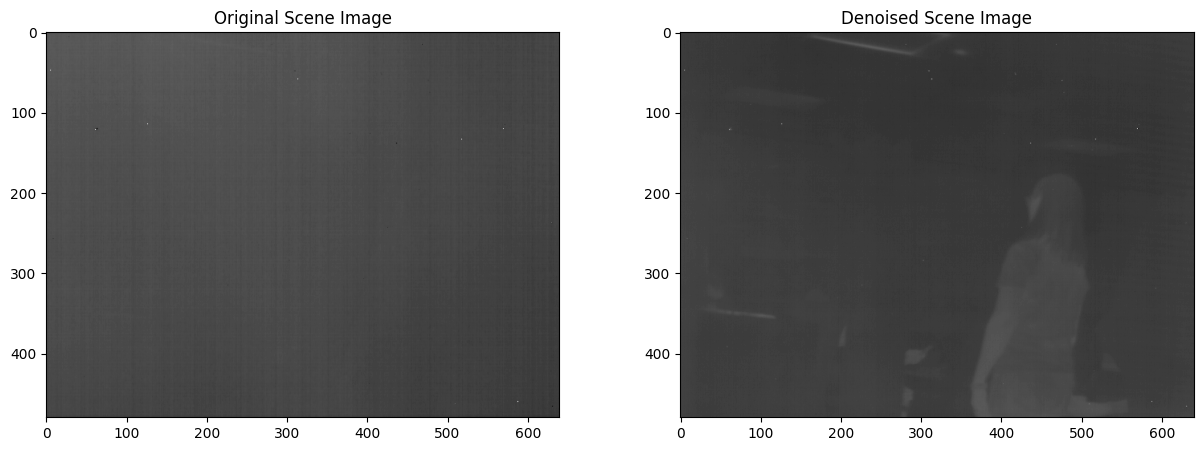

In [74]:
corrected_scene_images = applier(calibration_df_2,scene_df_1)
display(scene_df_1, corrected_scene_images,index=350)

# Without calibration

In [75]:
def slice_array(arr, num=10, stride=8):
    t, x, y = arr.shape
    
    slices = []
    
    for i in range(0, x - x // num + 1, stride):
        for j in range(0, y - y // num + 1, stride):
            slice_x_start = i
            slice_x_end = i + x // num
            slice_y_start = j
            slice_y_end = j + y // num
            
            slice_ij = arr[:, slice_x_start:slice_x_end, slice_y_start:slice_y_end]
            slices.append((slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end)))
    
    return slices

def rebuild_array(slices, original_shape, num=10):
    t, x, y = original_shape
    
    # Initialize an empty array with the original shape
    rebuilt_array = np.zeros((x, y))
    weight = np.zeros((x, y))
    
    for slice_ij, (slice_x_start, slice_x_end, slice_y_start, slice_y_end) in slices:
        rebuilt_array[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += slice_ij
        weight[slice_x_start:slice_x_end, slice_y_start:slice_y_end] += 1
    
    # Avoid division by zero
    weight[weight == 0] = 1
    return rebuilt_array / weight

In [76]:
def sorted_uniform_pictures(arr):
    """
    Sort (t, x, y) array's t slices from most uniform to least uniform.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array where the t slices are sorted by uniformity.
    """
    t, x, y = arr.shape
    
    # Compute the variance for each t slice
    variances = np.var(arr, axis=(1, 2))
    
    # Get the sorted indices based on variances
    sorted_indices = np.argsort(variances)
    
    # Extract and sort the t slices
    sorted_slices = arr[sorted_indices]
    
    return sorted_slices

def pick_regular_slices(arr, num=50):
    """
    Pick a tenth of all t slices in a regular order from a (t, x, y) array.

    Parameters:
    arr (np.ndarray): Input 3D array of shape (t, x, y).

    Returns:
    np.ndarray: A 3D array with a tenth of the t slices picked in a regular order.
    """
    t, x, y = arr.shape
    
    # Compute the indices to pick a tenth of the t slices at regular intervals
    step = t // num
    indices = np.arange(0, t, step)
    
    # Pick slices at the computed indices
    picked_slices = arr[indices]
    
    return picked_slices


In [77]:
def adjust_contrast(image, alpha, beta):
    """
    Adjust the contrast of a grayscale image.

    Parameters:
    image (np.ndarray): Input grayscale image as a NumPy array.
    alpha (float): Contrast control (1.0-3.0).
    beta (int): Brightness control (0-100).

    Returns:
    np.ndarray: Image with adjusted contrast.
    """
    # Apply the contrast adjustment
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    
    return adjusted_image

In [78]:
def pseud_calibration(df, num_slices):
    arr = process_data_np(df)
    slices = slice_array(arr, num_slices,4)
    t, x, y = arr.shape
    medslice = [sorted_uniform_pictures(s[0]) for s in slices]
    # original_means = [np.mean(s[0]) for s in slices]

    print(medslice[0].shape)
    tenth = [pick_regular_slices(s) for s in medslice]
    meaned = [np.mean(t, axis=0) for t in tenth]
    
    reconstructed = rebuild_array(list(zip(meaned, [(s[1][0], s[1][1], s[1][2], s[1][3]) for s in slices])), (t, x, y), num_slices)
    
    # Apply Gaussian blur to the reconstructed image to reduce block edges
    # smoothed_image = cv2.GaussianBlur(reconstructed, (5, 5), 0)
    
    return reconstructed

In [79]:
def applier(df):
    filter = pseud_calibration(df, 32)
    scene = process_data_np(df)
    filtered_scene = scene - filter
    corrected_scene = adjust_contrast(filtered_scene, alpha=1.1, beta=100)
    return corrected_scene


(400, 15, 20)


In [ ]:
corrected_img = applier(scene_df_1)

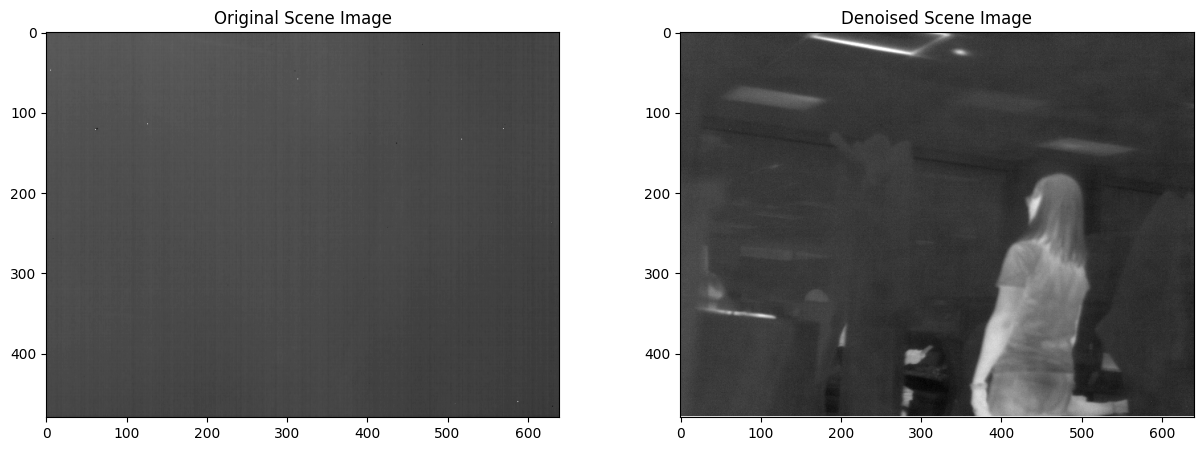

In [80]:
display(scene_df_1, corrected_img,index=350)